# <b>RISK BASED AND ROBUST PORTFOLIO SELECTION STRATEGIES</b>

#Installing and importing packages


In [0]:
!pip install cplex
!apt install coinor-libipopt-dev
!pip install ipopt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
coinor-libipopt-dev is already the newest version (3.11.9-2.1ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import cvxpy as cp
import ipopt
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline


## 1. Buy and hold strategy


In [0]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after holding.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  x_optimal = x_init
  cash_optimal = cash_init
  return x_optimal, cash_optimal

## 2. Equally weighted strategy

In [0]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the equally weighted strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account
  cur_prices: (1,20)  array of each day prices
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init                     # Initial portfolio value is computed
  m1=PV/20                                                 # value for each stock is calculated (PV/20 as it is equally weighted)
  w1=m1/cur_prices                                         # Weights for each stock are known by using current prices
  x_optimal= np.ceil(w1)                                 # optimal number of shares for initial period 
  tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
  cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
  if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
    while cash_optimal < 0 :
      index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
      for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
        if (x_optimal[mi])>0:
          x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
          cash_optimal+=tc
          tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
          cash_optimal+=(cur_prices[mi]-tc)
          break   
        else:
          continue
  # else: 
  #   x_optimal=np.ceil(w1)                                  # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
  #   cash_optimal= PV-sum(cur_prices*x_optimal)
       
  return x_optimal, cash_optimal

## 3. Minimum variance strategy

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [0]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the minimum variance strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  # initial computations
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  # Cplex functions
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  n=len(cur_prices)
  c  = [0.0] * n                                               # defining C, lower bounds, upper bounds
  lb = [0.0] * n
  ub = [1.0] * n
  # Appending A matrix
  A = []
  for k in range(n):
    A.append([[0],[1.0]])  

  # Defining variable names, constraints,Qmat                                            
  cpx.linear_constraints.add(rhs=[1.0], senses="E")
  var_names = ["w_%s" % i for i in range(1,n+1)]
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [(list(range(n)), list(2*Q[k,:])) for k in range(n)]
  cpx.objective.set_quadratic(Qmat)
  # Disable CPLEX output to screen
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  # Cplex solution and weight computation
  cpx.solve()
  w1 = np.array(cpx.solution.get_values())
  if cash_init==0:
    x_optimal=np.ceil( ( w1 * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w1 * PV ) /cur_prices)               # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
    cash_optimal= PV-sum(cur_prices*x_optimal)
  return x_optimal, cash_optimal 

## 4. Maximum Sharpe ratio strategy

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{y} & y^TQy \\
& w = y/k \\
{\rm s.t.} & \sum_i (u_i - r_f)y_i = 1\\
& \sum_i y_i = 1\\
& y \geq 0
\end{array}
\end{equation}

In [0]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  # Initial computations
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  n=len(cur_prices)
  # Cplex solver
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  c  = [0] * (n+1)                                      # inital and boundary conditions
  lb = [0] * (n+1)
  ub = [cplex.infinity] * (n+1)
  r_rf=0.025/252                                        # risk free rate over trading days
  # Appending A matrix
  A=[]
  for i in range(n):
    A.append([[0,1],[mu[i]-r_rf,1.0]])
  A.append([[0,1],[0,-1]])
  # Defining variable names, constraints,Qmat                                        
  cpx.linear_constraints.add(rhs=[1,0], senses="EE")
  var_names = ["w_%s" % i for i in range(1,n+2)]
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [[list(range(n+1)), list(2*np.append(Q[k,:],0))] for k in range(n)]
  Qmat.append([list(range(n+1)),[0]*(n+1)])
  cpx.objective.set_quadratic(Qmat)
  # Disable CPLEX output to screen
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  # Cplex solution and weight computation
  cpx.solve()
  w1 =np.array(cpx.solution.get_values()[0:20])/(cpx.solution.get_values()[-1])
  if cash_init==0:
    x_optimal=np.ceil( ( w1 * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w1 * PV ) /cur_prices)
    cash_optimal= PV-sum(cur_prices*x_optimal)
  return x_optimal, cash_optimal 

##5. Equal Risk Contribution Strategy

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

In [0]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  n=len(cur_prices)
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  w0 = [1.0/n]*n
  class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        y = x * np.dot(Q, x)
        RC= np.dot(Q,x)
        # Insert your gradient computations here
        for i in range(n):
          for j in range(n):
            for k in range(j+1,n):
              if i==j:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])+RC[i]-(Q[k][j]*x[k]))*(y[j]-y[k]))
              elif i==k:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])-RC[j]-(Q[j][j]*x[j]))*(y[j]-y[k]))
              else:
                grad[i]=grad[i]+ 4*(((Q[i][k]*x[i])-(Q[j][k]*x[j]))*(y[j]-y[k]))
        # You can use finite differences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

  # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

  # Set the IPOPT options
  nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.addOption('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc, info = nlp.solve(w0)
  if cash_init==0:
    x_optimal=np.ceil( ( w_erc * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w_erc * PV ) /cur_prices)               # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
    cash_optimal= PV-sum(cur_prices*x_optimal)
  return x_optimal, cash_optimal

##6. Leveraged Equal Risk Contribution Strategy

In [0]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  n=len(cur_prices)
  r_rf=0.025/6
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  w0 = [1.0/n]*n
  class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        y = x * np.dot(Q, x)
        RC= np.dot(Q,x)
        # Insert your gradient computations here
        for i in range(n):
          for j in range(n):
            for k in range(j+1,n):
              if i==j:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])+RC[i]-(Q[k][j]*x[k]))*(y[j]-y[k]))
              elif i==k:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])-RC[j]-(Q[j][j]*x[j]))*(y[j]-y[k]))
              else:
                grad[i]=grad[i]+ 4*(((Q[i][k]*x[i])-(Q[j][k]*x[j]))*(y[j]-y[k]))
        # You can use finite differences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

  # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

  # Set the IPOPT options
  nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.addOption('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc, info = nlp.solve(w0)
  if cash_init==0:
    x_optimal=np.ceil( ( w_erc * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc-(r_rf*init_value)          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w_erc * PV ) /cur_prices)               # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc-(r_rf*init_value)
  return x_optimal, cash_optimal

##7. Robust Optimization Startegy

\begin{equation}
  \begin{array}{lll}
    \min   & w^TQw       \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}
          \sum_{i=1}^n w_i & = & 1  \\
          \mu^T w & \geq & \varepsilon_{\rm ret} \\
          w^T \Theta w & \leq & \tilde{\varepsilon}_{\rm rob} \\
            w & \geq & 0
     \end{array}
  \end{array}
\end{equation}

In [0]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  # Cplex functions
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  n=len(cur_prices)
  c  = [0.0] * n                                               # defining C, lower bounds, upper bounds
  lb = [0.0] * n
  ub = [1.0] * n
  # Appending A matrix
  A = []
  for k in range(n):
    A.append([[0],[1.0]])  

  # Defining variable names, constraints,Qmat                                            
  cpx.linear_constraints.add(rhs=[1.0], senses="E")
  var_names = ["w_%s" % i for i in range(1,n+1)]
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [(list(range(n)), list(2*Q[k,:])) for k in range(n)]
  cpx.objective.set_quadratic(Qmat)
  # Disable CPLEX output to screen
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  # Cplex solution and weight computation
  cpx.solve()
  w_minVar = np.array(cpx.solution.get_values())
  var_matr = np.diag(np.diag(Q))
  var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar))
  ret_minVar = np.dot(mu, w_minVar)
  rob_minVar = np.dot(w_minVar, np.dot(var_matr, w_minVar))
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize) 
  c  = [0.0] * n
  lb = [0.0] * n
  ub = [1.0] * n
  A = []
  for k in range(n):
      A.append([[0,1],[1.0,mu[k]]])
  var_names = ["w_%s" % i for i in range(1,n+1)]
  cpx.linear_constraints.add(rhs=[1.0,ret_minVar], senses="EG")
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
  cpx.objective.set_quadratic(Qmat)
  Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
  cpx.quadratic_constraints.add(rhs=rob_minVar, quad_expr=Qcon, name="Qc")
  # Disable CPLEX output to screen
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  cpx.solve()
  w_rMV = np.array(cpx.solution.get_values())
  if cash_init==0:
    x_optimal=np.ceil( ( w_rMV * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w_rMV * PV ) /cur_prices)               # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
    cash_optimal= PV-sum(cur_prices*x_optimal)
  return x_optimal, cash_optimal

In [0]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
stock_names = np.array(df.columns[1:])
#print(stock_names)


In [0]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [0]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [0]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


Initial portfolio value = $ 1000002.12



In [0]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

In [0]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim ]

In [0]:
portf_value = [0] * N_strat
weights=np.zeros((N_strat, N_periods), dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
         if strategy==5:
           curr_positions=2*init_positions      # 200% long
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]


      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if period>=2:
          PV=sum(cur_prices*x[strategy, period-1])+ cash[strategy, period-1]
          tc=np.sum(cur_prices*abs(x[strategy, period-1]-x[strategy, period-1]))*0.005
          cash[strategy, period-1]= PV-sum(cur_prices*x[strategy, period-1])-tc
          if cash[strategy, period-1]<0:
            while cash[strategy, period-1] < 0:
              index_min = np.argsort(cur_prices)
              for mi in index_min:
                if (x[strategy, period-1][mi])>0:
                  while (x[strategy, period-1][mi])>0:
                    x[strategy, period-1][mi]= x[strategy, period-1][mi] - 1
                    cash[strategy, period-1]-=tc
                    tc=sum(cur_prices*abs(x[strategy, period-1]-x[strategy, period-2]))*0.005
                    cash[strategy, period-1]= cash[strategy, period-1]+cur_prices[mi]-tc  
                    break   
                  else:
                    continue      

      # Compute portfolio value
      if strategy==5:
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-init_value
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      else:
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))    

      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      weights[strategy,period-1]=((x[strategy,period-1])*cur_prices)/np.dot(x[strategy,period-1],cur_prices)
      # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
   print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")



Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992887.17, value end = $ 1019430.17
  Strategy "Mininum Variance Portfolio", value begin = $ 991453.19, value end = $ 1015504.56
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990056.03, value end = $ 1009750.20
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992762.53, value end = $ 1017837.49
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 981374.13, value end = $ 1030968.15
  Strategy "Robust Optimization Portfolio", value begin = $ 991457.57, value end = $ 1015498.20
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weig

In [0]:
ind=['Buy and Hold',"Equally Weighted Portfolio","Minimum Variance Portfolio","Maximum Sharpe Ratio Portfolio","Equal Risk Contribution","Leveraged Equal Risk","Robust Mean Variance"]
col=['period 1','period 2','period 3','period 4','period 5','period 6','period 7','period 8','period 9','period 10','period 11','period 12']
df1=pd.DataFrame(cash,index=ind,columns=col)
df1

,period 1,period 2,period 3,period 4,period 5,period 6,period 7,period 8,period 9,period 10,period 11,period 12
Buy and Hold,0,0,0,0,0,0,0,0,0,0,0,0
Equally Weighted Portfolio,1.89373,2.72024,1.98465,0.87597,0.347389,1.09121,0.530864,1.48785,0.414314,2.89412,1.10186,4.23712
Minimum Variance Portfolio,2.58157,0.32238,3.8167,6.42919,0.70084,0.811049,0.688342,6.5211,3.3227,26.3436,2.17452,0.467083
Maximum Sharpe Ratio Portfolio,3.7603,18.0214,39.4964,1.7092,1.17486,0.60499,1.93657,30.1773,2.98423,4.6129,4.29328,21.4731
Equal Risk Contribution,0.485554,1.79645,0.0864018,1.0677,0.503007,0.926621,2.53668,1.14058,1.47711,3.77684,6.74052,5.73343
Leveraged Equal Risk,1.97773,0.495376,1.24838,0.916716,0.64189,1.2553,0.519117,1.62892,1.64871,2.23249,6.67367,6.40719
Robust Mean Variance,2.33048,1.48853,11.3288,9.17917,1.53925,1.3481,7.41432,4.4639,11.1973,17.4229,3.19855,7.45271


# <b>Plots 2015-2016</b>

##<b>1. Daily Portfolio Values 2015-2016 - All Strategies</b>


---



*   Buy and Hold Strategy
*   Equally Weighted Strategy


*   Minimum Variance Strategy
*   Maximum Sharpe Ratio Strategy


*   Equal Risk Contribution Strategy
*   Leveraged Equal Risk Contribution Strategy


*   Robust Optimization Strategy









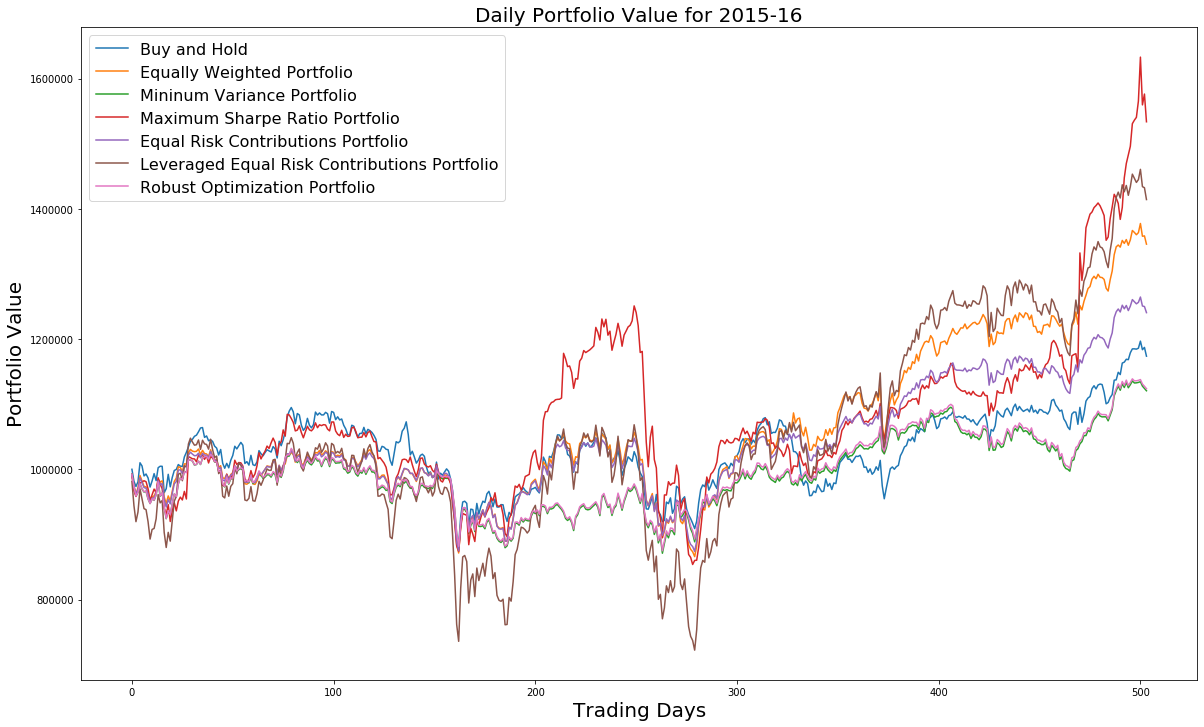

In [0]:
plt.figure(figsize=(20,12))
for i in range(N_strat):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2015-16',fontsize=20)
plt.show()

##<b>2. Dynamic Change of Portfolio allocation 2015-2016 </b>

In [0]:
Min_var_weights=[]
Max_sharpe_weights=[]
Rob_mean_var_weights=[]
for i in range(20):
  for j in range(12):
    Min_var_weights.append(weights[2][j][i])
    Max_sharpe_weights.append(weights[3][j][i])
    Rob_mean_var_weights.append(weights[6][j][i])

<b>2.1 Dynamic Change of Portfolio allocation - <font color='Blue'>"Minimum Variance Strategy"

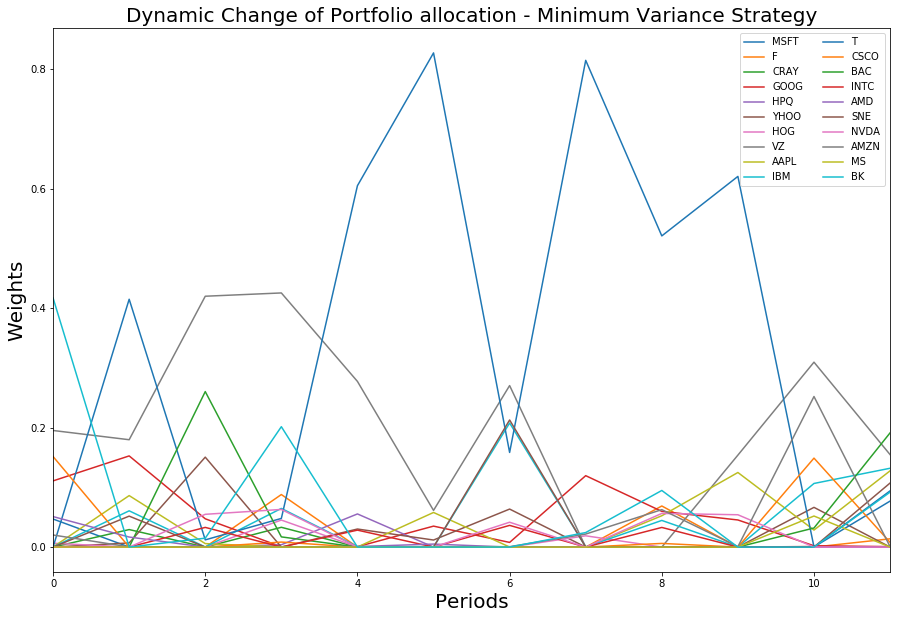

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Minimum Variance Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Min_var_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

<b>2.2 Dynamic Change of Portfolio allocation - <font color='Blue'> "Maximum Sharpe Ratio Strategy"</b>*

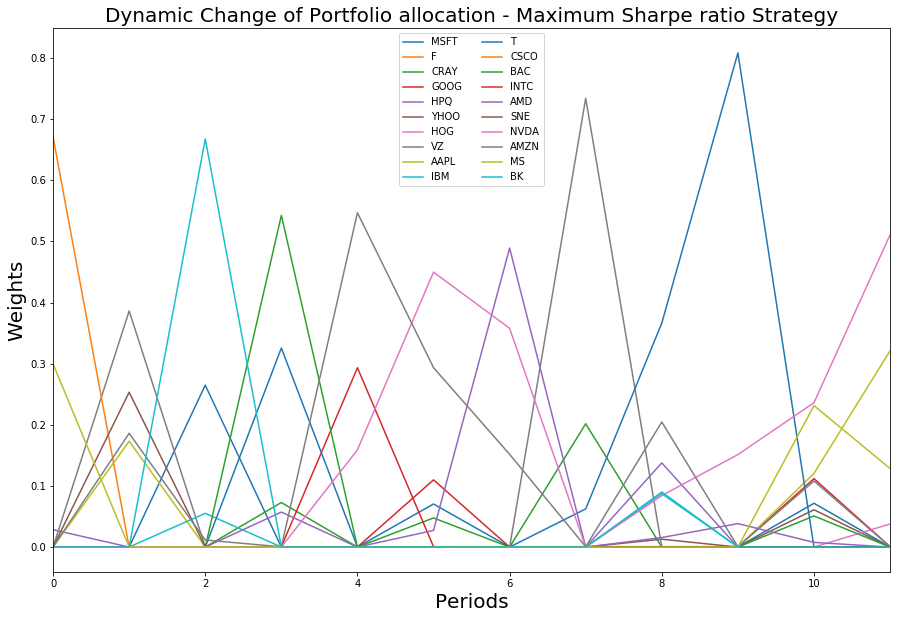

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Maximum Sharpe ratio Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Max_sharpe_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

<b>2.3 Dynamic Change of Portfolio allocation - <font color='Blue'> "Robust Mean variance Optimization Strategy"</b>

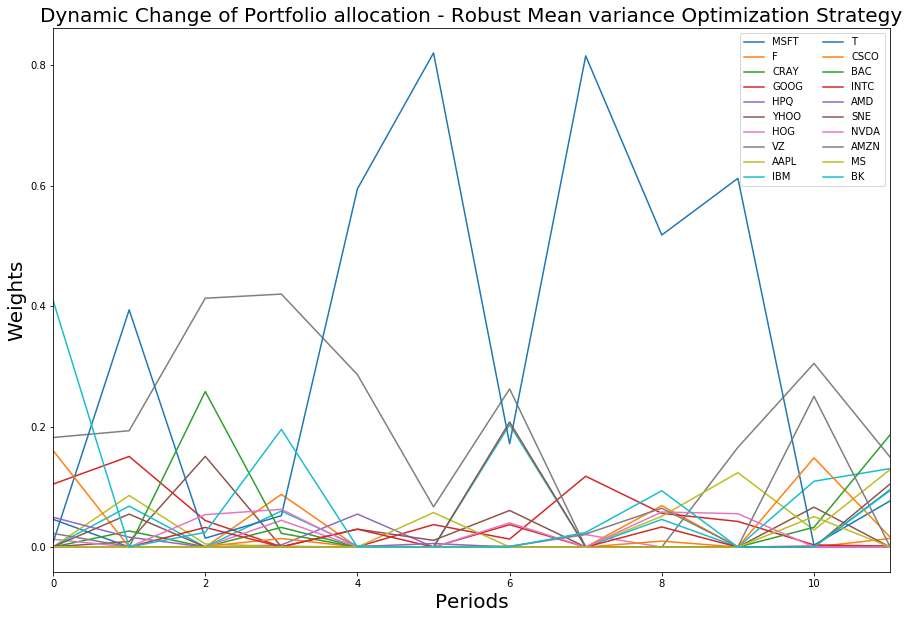

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Robust Mean variance Optimization Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Rob_mean_var_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

##<b>3.Comparing Strategies (2015-2016)</b>

<b>3.1 Comparing Daily Portfolio Values 2015-2016 - 5,6,7 Strategies</b>

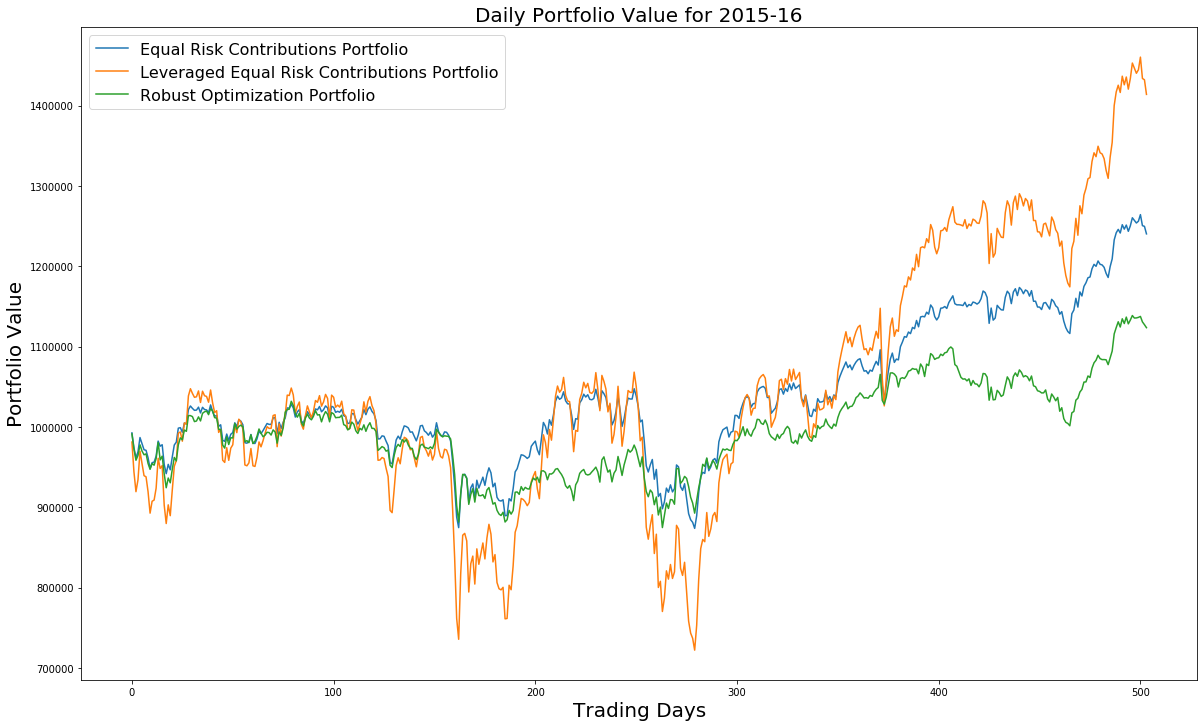

In [0]:
plt.figure(figsize=(20,12))
for i in range(4,N_strat):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2015-16',fontsize=20)
plt.show()

<b>3.2 Comparing Daily Portfolio Values 2015-2016 - 1,2,3,4,5 Strategies</b>

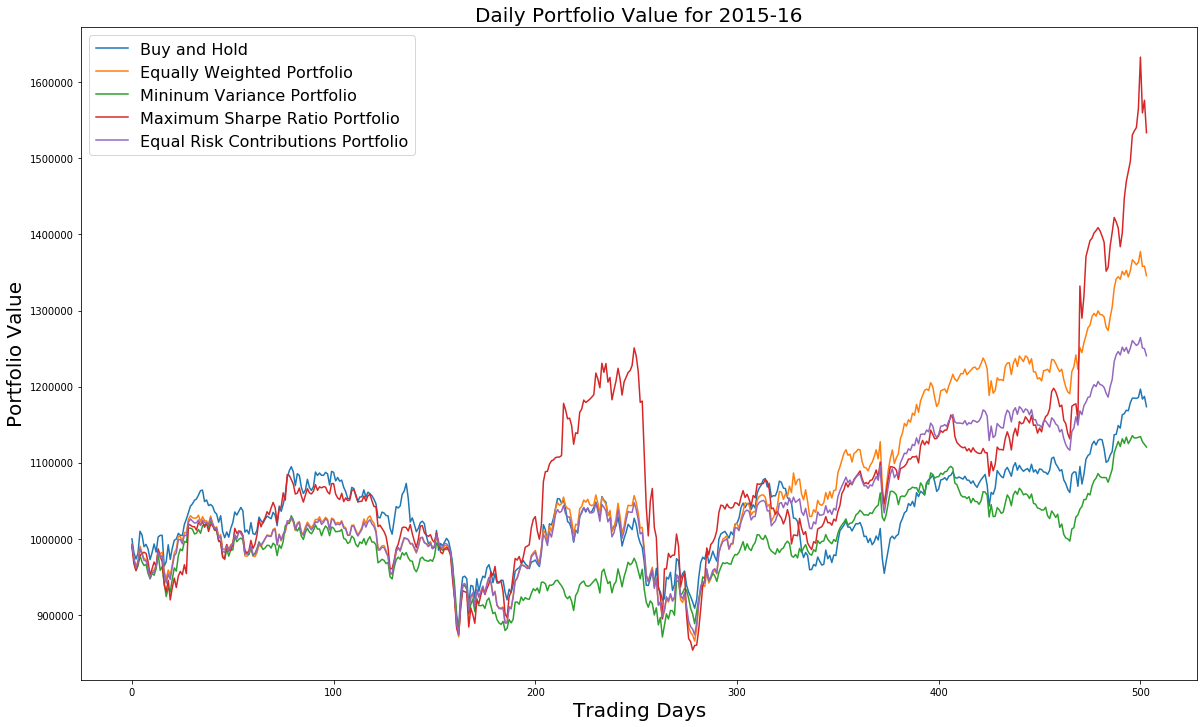

In [0]:
plt.figure(figsize=(20,12))
for i in range(5):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2015-16',fontsize=20)
plt.show()

<b>3.3 Comparing Daily Portfolio Values 2015-2016 - 1,2,3,4,6 Strategies</b>

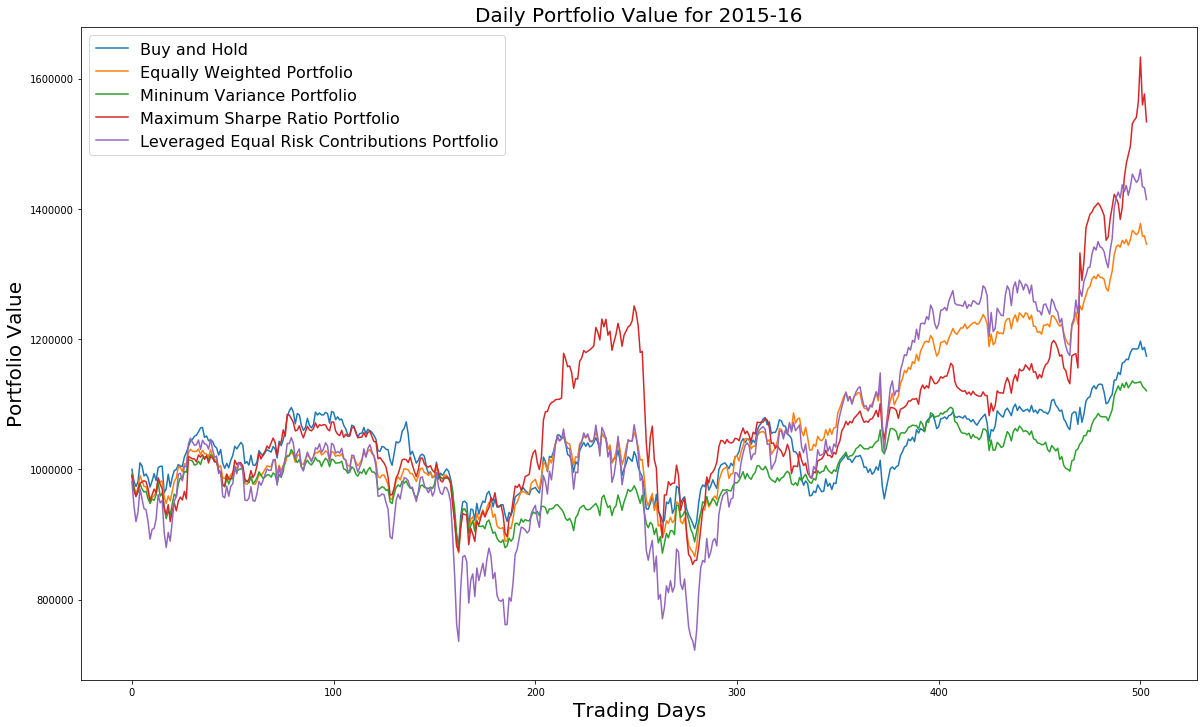

In [0]:
plt.figure(figsize=(20,12))
l=[0,1,2,3,5]
for i in l:
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2015-16',fontsize=20)
plt.show()

<b>3.4 Comparing Daily Portfolio Values 2015-2016 - 1,2,3,4,7 Strategies</b>

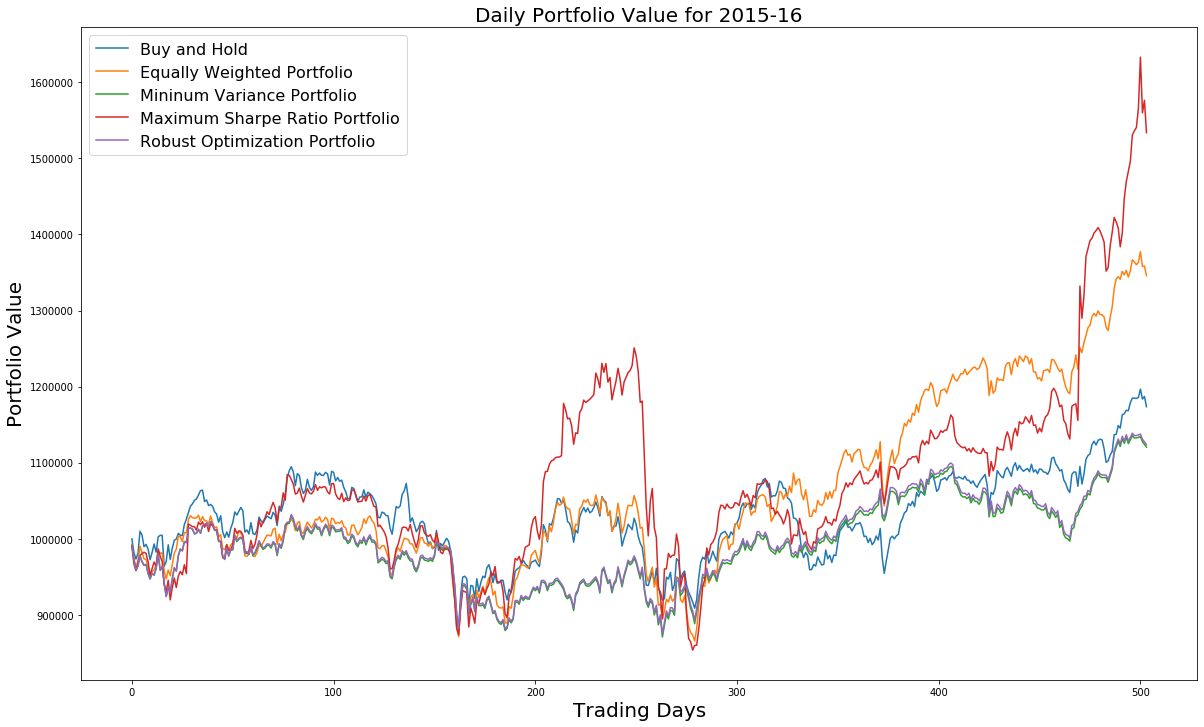

In [0]:
plt.figure(figsize=(20,12))
l=[0,1,2,3,6]
for i in l:
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='upper left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2015-16',fontsize=20)
plt.show()

# Portfolio Strategies in 2008-2009

Maximum Sharpe ratio strategy

In [0]:
def strat_max_Sharpe89(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  # Initial computations
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  n=len(cur_prices)
  # Cplex solver
  cpx = cplex.Cplex()
  cpx.objective.set_sense(cpx.objective.sense.minimize)
  c  = [0] * (n+1)                                      # inital and boundary conditions
  lb = [0] * (n+1)
  ub = [cplex.infinity] * (n+1)
  r_rf=0.045/252                                        # risk free rate over trading days
  # Appending A matrix
  A=[]
  for i in range(n):
    A.append([[0,1],[mu[i]-r_rf,1.0]])
  A.append([[0,1],[0,-1]])
  # Defining variable names, constraints,Qmat                                        
  cpx.linear_constraints.add(rhs=[1,0], senses="EE")
  var_names = ["w_%s" % i for i in range(1,n+2)]
  cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
  Qmat = [[list(range(n+1)), list(2*np.append(Q[k,:],0))] for k in range(n)]
  Qmat.append([list(range(n+1)),[0]*(n+1)])
  cpx.objective.set_quadratic(Qmat)
  # Disable CPLEX output to screen
  cpx.set_results_stream(None)
  cpx.set_warning_stream(None)
  # Cplex solution and weight computation
  try: 
    cpx.solve()
    w1 =np.array(cpx.solution.get_values()[0:20])/(cpx.solution.get_values()[-1])
  except:
    w1=((x_init*cur_prices)/PV)
  if cash_init==0:
    x_optimal=np.ceil( ( w1 * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w1 * PV ) /cur_prices)
    cash_optimal= PV-sum(cur_prices*x_optimal)
  return x_optimal, cash_optimal 

Leverage Equal Risk Contribution (2008-2009)

In [0]:
def strat_lever_equal_risk_contr89(x_init, cash_init, mu, Q, cur_prices):
  '''
  This function is defined to compute the optimal values 
  of x and cash after rebalncing using the maximum sharpe ratio strategy.
  Inputs:-
  x_init: (1,20) array of initial quantity of shares in each of 20 stocks
  cash_init: (1,20) array of initial cash in the cash account 
  cur_prices: (1,20)  array of each day prices
  mu: obtained returns
  Q: obtained variance
  Outputs:-
  x_optimal:(1,20) array of optimal quantity of shares in each of 20 stocks
  cash_optimal: (1,20) array of optimal cash in the cash account 

  '''
  n=len(cur_prices)
  r_rf=0.045/6
  cash_init=0
  PV=sum(cur_prices*x_init)+ cash_init
  w0 = [1.0/n]*n
  class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        y = x * np.dot(Q, x)
        RC= np.dot(Q,x)
        # Insert your gradient computations here
        for i in range(n):
          for j in range(n):
            for k in range(j+1,n):
              if i==j:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])+RC[i]-(Q[k][j]*x[k]))*(y[j]-y[k]))
              elif i==k:
                grad[i]=grad[i]+ 4*(((Q[i][j]*x[i])-RC[j]-(Q[j][j]*x[j]))*(y[j]-y[k]))
              else:
                grad[i]=grad[i]+ 4*(((Q[i][k]*x[i])-(Q[j][k]*x[j]))*(y[j]-y[k]))
        # You can use finite differences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

  # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

  lb = [0.0] * n  # lower bounds on variables
  ub = [1.0] * n  # upper bounds on variables
  cl = [1]        # lower bounds on constraints
  cu = [1]        # upper bounds on constraints

  # Define IPOPT problem
  nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

  # Set the IPOPT options
  nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
  nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
  nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
  nlp.addOption('tol'.encode('utf-8'), 1e-10)

  # Solve the problem
  w_erc, info = nlp.solve(w0)
  if cash_init==0:
    x_optimal=np.ceil( ( w_erc * PV ) /cur_prices)            # optimal number of shares for initial period 
    tc=sum(cur_prices*abs(x_init-x_optimal))*0.005         # Calculating transaction cost
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc-(r_rf*init_value)          # Computing optimal cash
    if cash_optimal<0:                                     # If the ceiling of no. of shares makes optimal cash negative
      while cash_optimal < 0 :
        index_min = np.argsort(cur_prices)                 # Sorting current prices based on the increasing order into an index
        for mi in index_min:                               # Now this loop takes every stock into account by checking if they > 0
          if (x_optimal[mi])>0:
            x_optimal[mi]= x_optimal[mi] - 1               # Here the optimal shares are reduced by '1' and the loop continues till optimal cash is positive
            cash_optimal+=tc
            tc=sum(cur_prices*abs(x_init-x_optimal))*0.005
            cash_optimal+=(cur_prices[mi]-tc)
            break   
          else:
            continue
  else: 
    x_optimal=np.ceil(( w_erc * PV ) /cur_prices)               # if there is any initial cash provided then ceil the values and compute transaction cost and cash optimal            
    cash_optimal= PV-sum(cur_prices*x_optimal)-tc-(r_rf*init_value)
  return x_optimal, cash_optimal

In [0]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df1 = pd.read_csv(input_file_prices)
stock_names = np.array(df1.columns[1:])
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df1['Date'].apply(convert_date_to_array)))
data_prices = df1.iloc[:, 1:].to_numpy()
dates = np.array(df1['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)


In [0]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [0]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


Initial portfolio value = $ 548247.97



In [0]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe89', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr89', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 6  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe89, strat_equal_risk_contr, strat_lever_equal_risk_contr89, strat_robust_optim ]

##Portfolio Results in 2008-2009

In [0]:
portf_value = [0] * N_strat
weights=np.zeros((N_strat, N_periods), dtype=np.ndarray)
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
         if strategy==5:
           curr_positions=2*init_positions
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]


      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if period>=2:
          PV=sum(cur_prices*x[strategy, period-1])+ cash[strategy, period-1]
          tc=np.sum(cur_prices*abs(x[strategy, period-1]-x[strategy, period-1]))*0.005
          cash[strategy, period-1]= PV-sum(cur_prices*x[strategy, period-1])-tc
          if cash[strategy, period-1]<0:
            while cash[strategy, period-1] < 0:
              index_min = np.argsort(cur_prices)
              for mi in index_min:
                if (x[strategy, period-1][mi])>0:
                  while (x[strategy, period-1][mi])>0:
                    x[strategy, period-1][mi]= x[strategy, period-1][mi] - 1
                    cash[strategy, period-1]-=tc
                    tc=sum(cur_prices*abs(x[strategy, period-1]-x[strategy, period-2]))*0.005
                    cash[strategy, period-1]= cash[strategy, period-1]+cur_prices[mi]-tc  
                    break   
                  else:
                    continue      

      # Compute portfolio value
      if strategy==5:
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-init_value
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      else:
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))    

      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      weights[strategy,period-1]=((x[strategy,period-1])*cur_prices)/np.dot(x[strategy,period-1],cur_prices)
      # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)
   print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544335.39, value end = $ 470262.11
  Strategy "Mininum Variance Portfolio", value begin = $ 543917.15, value end = $ 460817.27
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542793.88, value end = $ 473519.75
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544303.19, value end = $ 471964.10
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 536266.07, value end = $ 392406.70
  Strategy "Robust Optimization Portfolio", value begin = $ 543925.57, value end = $ 460629.00
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portf

CPLEX Error  1217: No solution exists.


  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 440130.40, value end = $ 437774.88
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 459743.69, value end = $ 462983.20
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 355298.41, value end = $ 360985.50
  Strategy "Robust Optimization Portfolio", value begin = $ 494053.64, value end = $ 497170.47
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Period 5: start date 9/2/2008, end date 10/31/2008
  Strategy "Buy and Hold", value begin = $ 478985.24, value end = $ 369998.60
  Strategy "Equally Weighted Portfolio", value begin = $ 451290.65, value end = $ 316531.63
  Strategy "Mininum Variance Portfolio", value begin = $ 486173.10, value end = $ 373693.99
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 425160.03, value end = $ 295522.34
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 4

In [0]:


ind=['Buy and Hold',"Equally Weighted Portfolio","Minimum Variance Portfolio","Maximum Sharpe Ratio Portfolio","Equal Risk Contribution","Leveraged Equal Risk","Robust Mean Variance"]
col=['period 1','period 2','period 3','period 4','period 5','period 6','period 7','period 8','period 9','period 10','period 11','period 12']
df1=pd.DataFrame(cash,index=ind,columns=col)
df1

,period 1,period 2,period 3,period 4,period 5,period 6,period 7,period 8,period 9,period 10,period 11,period 12
Buy and Hold,0,0,0,0,0,0,0,0,0,0,0,0
Equally Weighted Portfolio,0.096812,4.56319,5.35442,0.539678,2.47249,1.16501,1.37285,0.271438,1.68941,2.26946,3.69321,3.17021
Minimum Variance Portfolio,3.85617,1.53059,20.7985,2.37936,10.7038,1.98944,14.4453,1.19473,2.4389,14.4308,5.75524,7.43743
Maximum Sharpe Ratio Portfolio,15.3065,18.9253,6.44854,0.429153,1.24304,8.91976,1.00366,1.16533,0.679209,0.807347,3.23726,23.2152
Equal Risk Contribution,0.91063,4.07222,2.86259,4.42723,0.409176,1.71846,0.401665,1.85925,2.05031,1.69212,0.841526,1.75201
Leveraged Equal Risk,4.32274,3.26362,0.10858,0.0631944,2.67723,0.262564,1.52037,0.783398,1.63155,3.82551,0.581065,1.02052
Robust Mean Variance,5.61286,0.370053,2.56851,3.79866,9.85674,1.42492,6.11702,0.180375,1.75689,3.18151,11.278,4.27291


## Plots 2008-2009

###<b>1. Daily Portfolio Values 2008-2009 - All Strategies</b>


---



*   Buy and Hold Strategy
*   Equally Weighted Strategy


*   Minimum Variance Strategy
*   Maximum Sharpe Ratio Strategy


*   Equal Risk Contribution Strategy
*   Leveraged Equal Risk Contribution Strategy


*   Robust Optimization Strategy

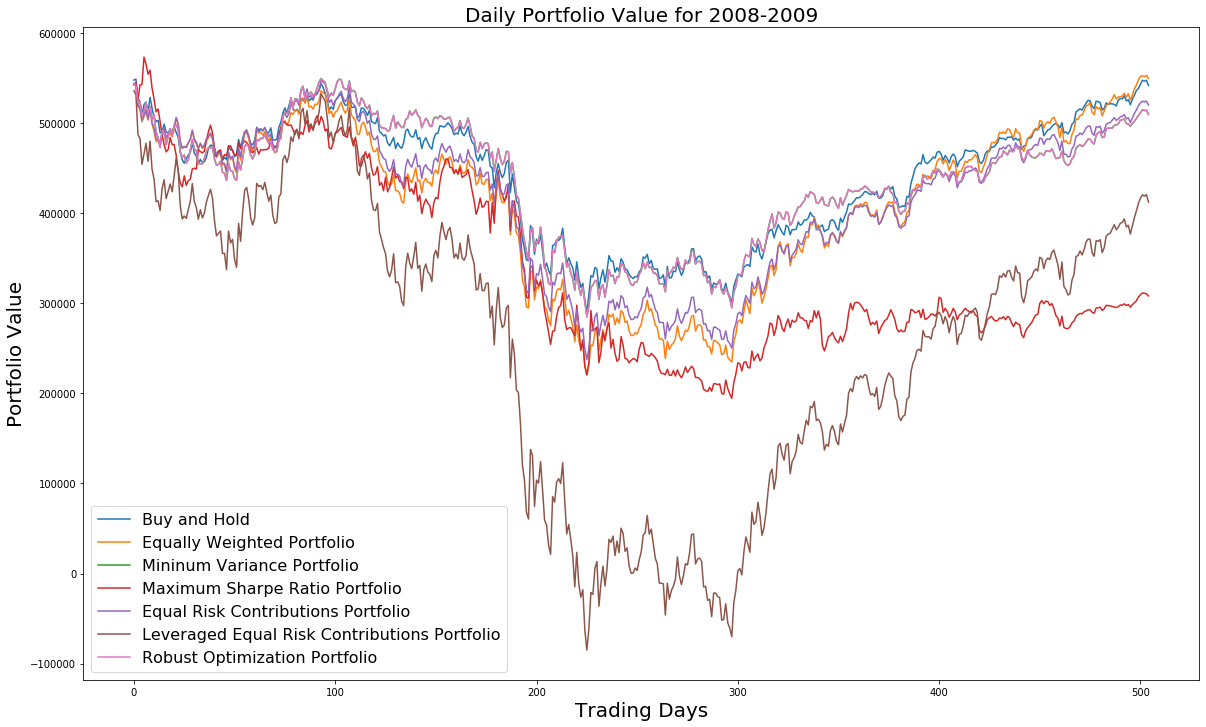

In [0]:
plt.figure(figsize=(20,12))
for i in range(N_strat):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2008-2009',fontsize=20)
plt.show()

###<b>2. Dynamic Change of Portfolio allocation 2008-2009 </b>

In [0]:
Min_var_weights=[]
Max_sharpe_weights=[]
Rob_mean_var_weights=[]
for i in range(20):
  for j in range(12):
    Min_var_weights.append(weights[2][j][i])
    Max_sharpe_weights.append(weights[3][j][i])
    Rob_mean_var_weights.append(weights[6][j][i])

<b>2.1 Dynamic Change of Portfolio allocation - <font color='Blue'>"Minimum Variance Strategy"

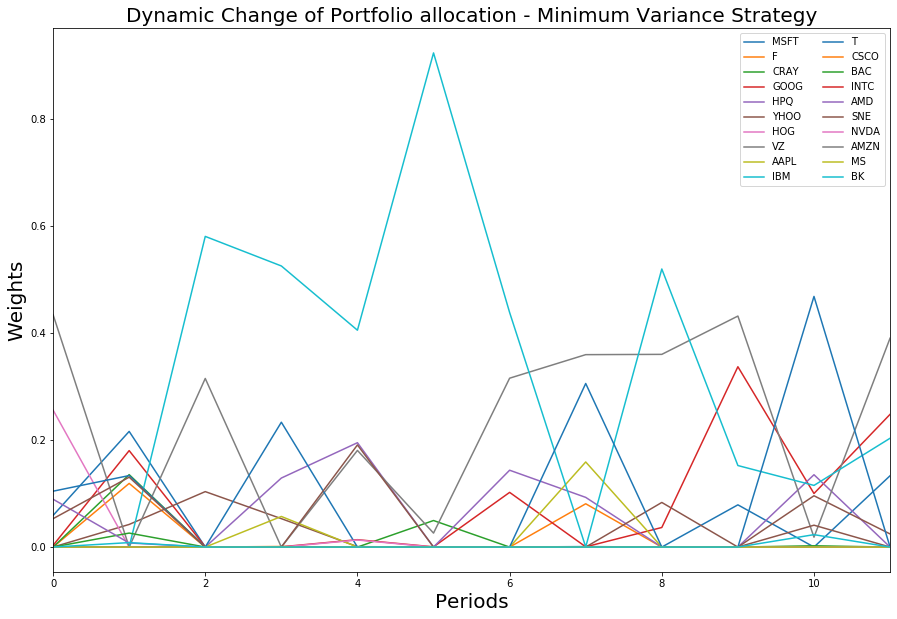

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Minimum Variance Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Min_var_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

<b>2.2 Dynamic Change of Portfolio allocation - <font color='Blue'> "Maximum Sharpe Ratio Strategy"</b>

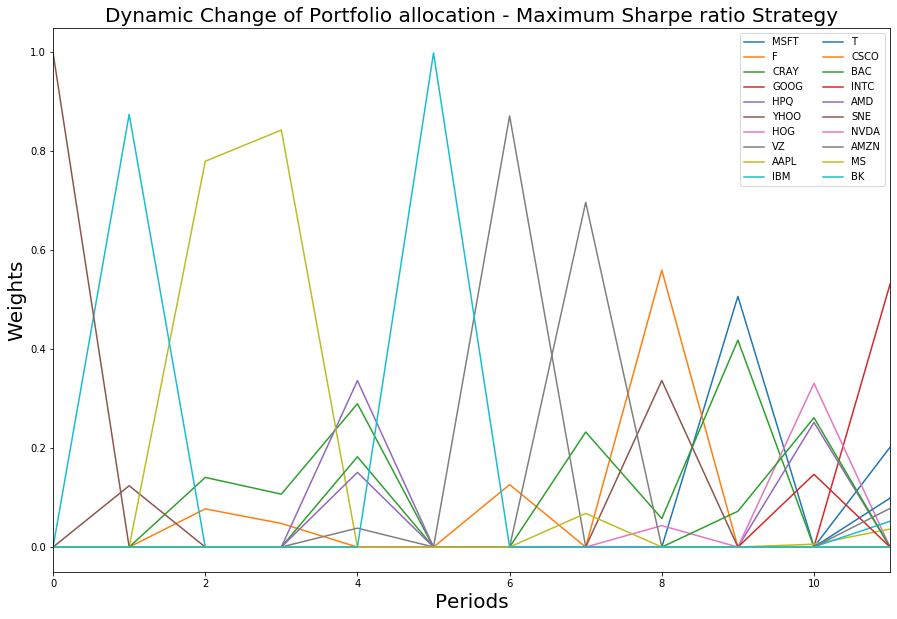

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Maximum Sharpe ratio Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Max_sharpe_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

<b>2.3 Dynamic Change of Portfolio allocation - <font color='Blue'> "Robust Mean variance Optimization Strategy"</b>

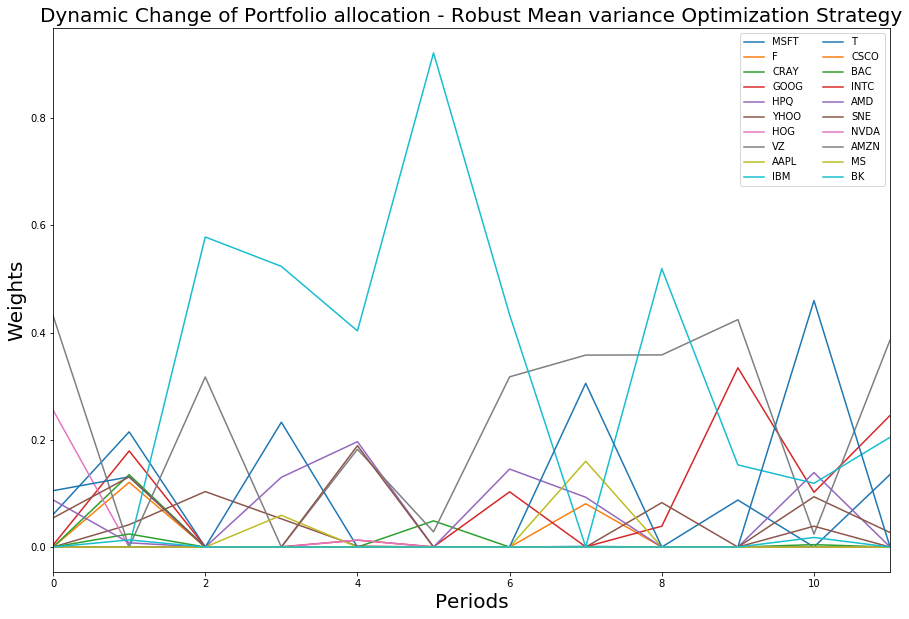

In [0]:
plt.figure(figsize=(15,10))
plt.title("Dynamic Change of Portfolio allocation - Robust Mean variance Optimization Strategy", fontsize=20)
plt.xlabel("Periods", fontsize=20)
plt.ylabel("Weights", fontsize=20)
plt.xlim(0,11)
for i in range(20):
  plt.plot(Rob_mean_var_weights[12*i :  12*i + 12], label = stock_names[i])
plt.legend(loc=0,ncol=2)
plt.show()

###<b>3.Comparing Strategies (2008-2009)</b>

<b>3.1 Comparing Daily Portfolio Values 2008-2009 - 5,6,7 Strategies</b>

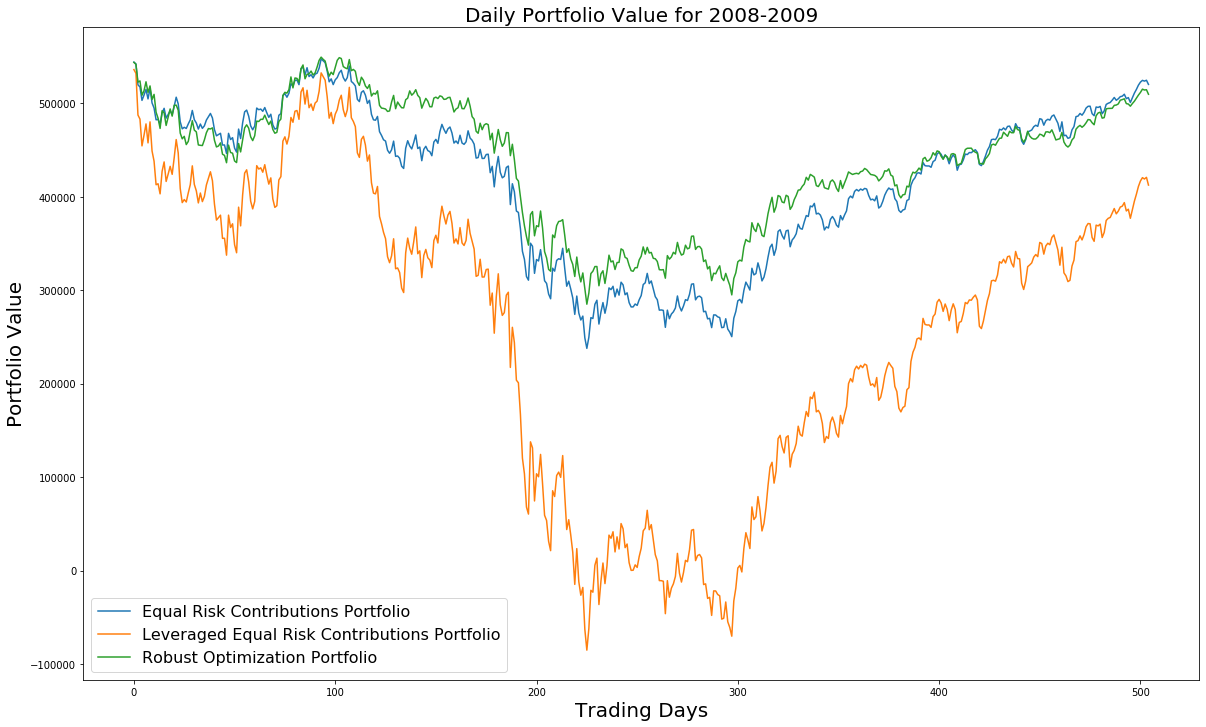

In [0]:
plt.figure(figsize=(20,12))
for i in range(4,N_strat):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2008-2009',fontsize=20)
plt.show()

<b>3.2 Comparing Daily Portfolio Values 2008-2009 - 1,2,3,4,5 Strategies</b>

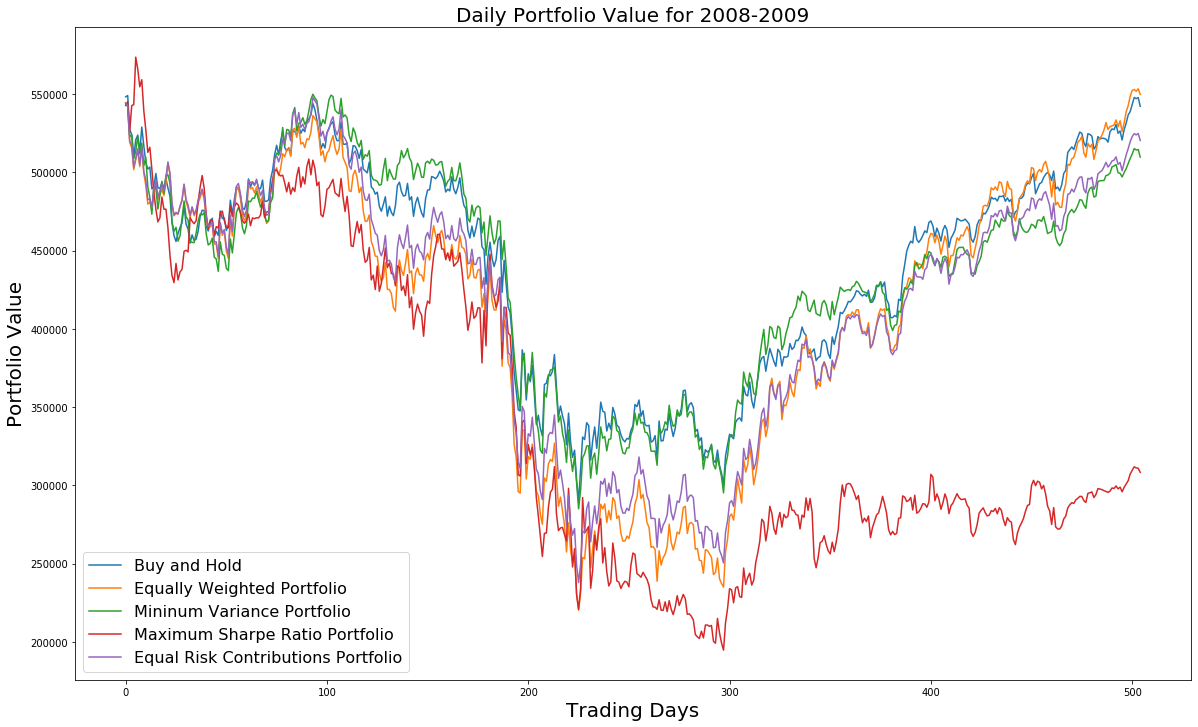

In [0]:
plt.figure(figsize=(20,12))
for i in range(5):
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2008-2009',fontsize=20)
plt.show()

<b>3.3 Comparing Daily Portfolio Values 2008-2009 - 1,2,3,4,6 Strategies</b>

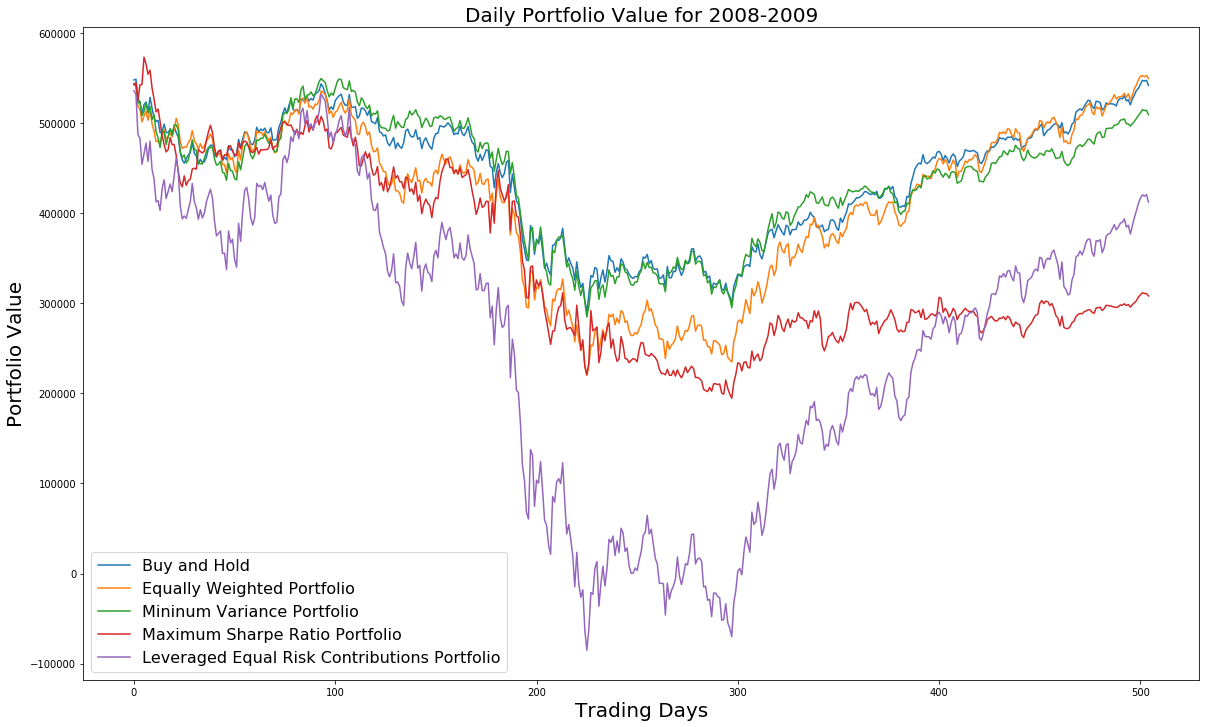

In [0]:
plt.figure(figsize=(20,12))
l=[0,1,2,3,5]
for i in l:
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2008-2009',fontsize=20)
plt.show()

<b>3.4 Comparing Daily Portfolio Values 2008-2009 - 1,2,3,4,7 Strategies</b>

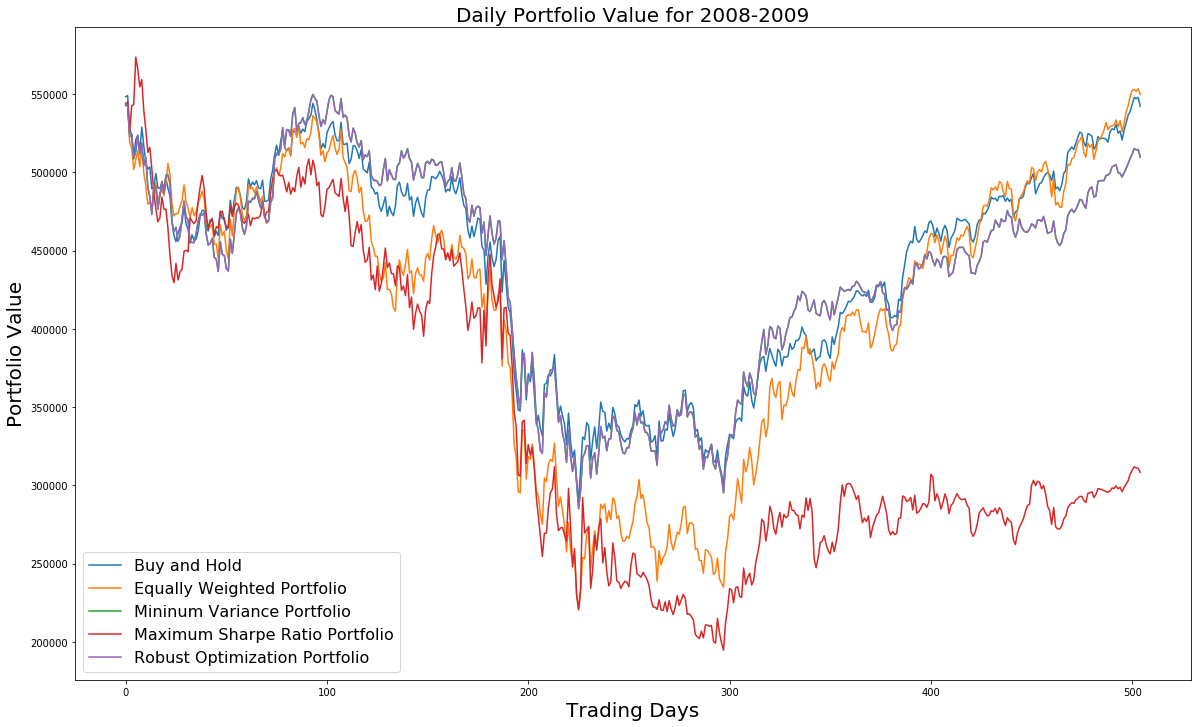

In [0]:
plt.figure(figsize=(20,12))
l=[0,1,2,3,6]
for i in l:
  Pvalues= portf_value[i]
  plt.plot(Pvalues, label=strategy_names[i])
plt.legend(loc='lower left', fontsize=16)
plt.xlabel('Trading Days',fontsize=20)
plt.ylabel('Portfolio Value',fontsize=20)
plt.title('Daily Portfolio Value for 2008-2009',fontsize=20)
plt.show()